# Preprocessing danych

In [541]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [542]:
money = 100000
debt = 250000

print("cheap: ", 0, " - ",money)
print("average: ", money, " - ", debt+money)
print("expensive: ", debt+money, " - ", "inf")

cheap:  0  -  100000
average:  100000  -  350000
expensive:  350000  -  inf


# Initial data viewing

In [543]:
with open('zadanie_studenci/train_data.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)

df = pd.DataFrame(data[1:], columns=data[0])
test_df = pd.read_csv('zadanie_studenci/test_data.csv')

missing_values = df.isnull().sum()
print(missing_values)

SalePrice                    0
YearBuilt                    0
Size(sqf)                    0
Floor                        0
HallwayType                  0
HeatingType                  0
AptManageType                0
N_Parkinglot(Ground)         0
N_Parkinglot(Basement)       0
TimeToBusStop                0
TimeToSubway                 0
N_manager                    0
N_elevators                  0
SubwayStation                0
N_FacilitiesInApt            0
N_FacilitiesNearBy(Total)    0
N_SchoolNearBy(Total)        0
dtype: int64


In [544]:
df.describe()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
count,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124,4124
unique,841,16,89,43,3,2,2,23,20,3,5,9,13,8,9,11,14
top,149274,2007,914,4,terraced,individual_heating,management_in_trust,67.0,536.0,0~5min,0-5min,6.0,0.0,Kyungbuk_uni_hospital,4,9.0,17.0
freq,38,881,683,228,2485,3938,3869,512,690,3148,1960,1017,735,1125,1003,1493,824


In [545]:
columns_with_types = {}

for column in df.columns:
    numeric_series = pd.to_numeric(df[column], errors='coerce')

    if not numeric_series.isna().any():
        if (numeric_series == numeric_series.astype(int)).all():
            print(f"{column} has type: int")
            columns_with_types[column] = "int"
        else:
            print(f"{column} has type: float")
            columns_with_types[column] = "float"
    else:
        print(f"{column} has type: string")
        columns_with_types[column] = "string"


SalePrice has type: int
YearBuilt has type: int
Size(sqf) has type: int
Floor has type: int
HallwayType has type: string
HeatingType has type: string
AptManageType has type: string
N_Parkinglot(Ground) has type: int
N_Parkinglot(Basement) has type: int
TimeToBusStop has type: string
TimeToSubway has type: string
N_manager has type: int
N_elevators has type: int
SubwayStation has type: string
N_FacilitiesInApt has type: int
N_FacilitiesNearBy(Total) has type: int
N_SchoolNearBy(Total) has type: int


In [546]:
columns_with_types

{'SalePrice': 'int',
 'YearBuilt': 'int',
 'Size(sqf)': 'int',
 'Floor': 'int',
 'HallwayType': 'string',
 'HeatingType': 'string',
 'AptManageType': 'string',
 'N_Parkinglot(Ground)': 'int',
 'N_Parkinglot(Basement)': 'int',
 'TimeToBusStop': 'string',
 'TimeToSubway': 'string',
 'N_manager': 'int',
 'N_elevators': 'int',
 'SubwayStation': 'string',
 'N_FacilitiesInApt': 'int',
 'N_FacilitiesNearBy(Total)': 'int',
 'N_SchoolNearBy(Total)': 'int'}

In [547]:
numerical_columns = []
categorical_columns = []

for column, _type in columns_with_types.items():
    if _type == "int" or _type == "float":
        numerical_columns.append(column)
    else:
        categorical_columns.append(column)

print("Numerical columns: ", numerical_columns)
print("Categorical columns: ", categorical_columns)

Numerical columns:  ['SalePrice', 'YearBuilt', 'Size(sqf)', 'Floor', 'N_Parkinglot(Ground)', 'N_Parkinglot(Basement)', 'N_manager', 'N_elevators', 'N_FacilitiesInApt', 'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
Categorical columns:  ['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation']


In [548]:
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric, errors='coerce')

In [549]:
for colm in categorical_columns:
    value_counts = df[colm].value_counts()
    print(f"{colm} has unique values: {value_counts.to_dict()}")

HallwayType has unique values: {'terraced': 2485, 'mixed': 1194, 'corridor': 445}
HeatingType has unique values: {'individual_heating': 3938, 'central_heating': 186}
AptManageType has unique values: {'management_in_trust': 3869, 'self_management': 255}
TimeToBusStop has unique values: {'0~5min': 3148, '5min~10min': 938, '10min~15min': 38}
TimeToSubway has unique values: {'0-5min': 1960, '5min~10min': 792, '15min~20min': 682, '10min~15min': 526, 'no_bus_stop_nearby': 164}
SubwayStation has unique values: {'Kyungbuk_uni_hospital': 1125, 'Myung-duk': 1065, 'Banwoldang': 531, 'Bangoge': 512, 'Sin-nam': 468, 'no_subway_nearby': 276, 'Chil-sung-market': 85, 'Daegu': 62}


In [550]:
df['SalePrice'] = df['SalePrice'].astype(int)

min_target = df['SalePrice'].min()
max_target = df['SalePrice'].max()

def categorize_target(value):
    if value < money:
        return 0
    elif value < debt + money:
        return 1
    else:
        return 2

df['price_category'] = df['SalePrice'].apply(categorize_target)
df.drop(columns=['SalePrice'], inplace=True)

target_counts = df['price_category'].value_counts().to_dict()

print("Target counts: ", target_counts)
print("Max target: ", max_target)
print("Min target: ", min_target)

Target counts:  {1: 2998, 2: 570, 0: 556}
Max target:  585840
Min target:  34070


# With this knowledge we start data preprocessing

- Plan is like this: for now to leave the numerical vals as they are and to just convert the data to ints
- for coulumns TimeToBusStop, TimeToSubway do index encoding, as is thinkt that actually it will be good for the model to have a correlation that 10-15 minutes is closer to 5-10mins then 0-5 mins
- turn year built to years old

# Label encoding

In [551]:
idx_bus_stop = data[0].index("TimeToBusStop")
idx_subway = data[0].index("TimeToSubway")
idx_heating = data[0].index("HeatingType")
idx_apt_manage = data[0].index("AptManageType")

bus_stop_mapping_str_to_int = {"0~5min": 3, "5min~10min": 2, "10min~15min": 1}
bus_stop_mapping_int_to_str = {v: k for k, v in bus_stop_mapping_str_to_int.items()}

subway_mapping_str_to_int = {"no_bus_stop_nearby": 0, "0-5min": 4, "5min~10min": 3, "10min~15min": 2, "15min~20min": 1}
subway_mapping_int_to_str = {v: k for k, v in subway_mapping_str_to_int.items()}

heat_mapping_str_to_int = {"individual_heating": 1, "central_heating": 0}
heat_mapping_int_to_str = {v: k for k, v in heat_mapping_str_to_int.items()}

apt_mapping_str_to_int = {"management_in_trust": 1, "self_management": 0}
apt_mapping_int_to_str = {v: k for k, v in apt_mapping_str_to_int.items()}

df['TimeToBusStop'] = df['TimeToBusStop'].map(bus_stop_mapping_str_to_int)
df['TimeToSubway'] = df['TimeToSubway'].map(subway_mapping_str_to_int)
df['HeatingType'] = df['HeatingType'].map(heat_mapping_str_to_int)
df['AptManageType'] = df['AptManageType'].map(apt_mapping_str_to_int)

print(df[['TimeToBusStop', 'TimeToSubway', 'HeatingType', 'AptManageType']].head())

print("Unique values in TimeToBusStop:", df['TimeToBusStop'].unique())
print("Unique values in TimeToSubway:", df['TimeToSubway'].unique())
print("Unique values in HeatingType:", df['HeatingType'].unique())
print("Unique values in AptManageType:", df['AptManageType'].unique())

   TimeToBusStop  TimeToSubway  HeatingType  AptManageType
0              2             2            1              1
1              3             3            1              0
2              3             3            1              0
3              3             4            1              1
4              2             1            1              0
Unique values in TimeToBusStop: [2 3 1]
Unique values in TimeToSubway: [2 3 4 1 0]
Unique values in HeatingType: [1 0]
Unique values in AptManageType: [1 0]


In [552]:
df.describe(include='all')

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),price_category
count,4124.000000,4124.000000,4124.000000,4124,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124,4124.000000,4124.000000,4124.000000,4124.000000
unique,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,terraced,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kyungbuk_uni_hospital,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,2485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1125,NaN,NaN,NaN,NaN
mean,2002.977934,959.958778,11.994665,NaN,0.954898,0.938167,192.789040,572.857662,2.754122,2.897672,6.313773,11.055771,NaN,5.824200,9.860330,10.872696,1.003395
std,8.765838,384.548456,7.581330,NaN,0.207553,0.240882,215.455916,408.179957,0.451553,1.269697,3.224556,7.717030,NaN,2.344331,3.444848,4.427445,0.522581
min,1978.000000,135.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000
25%,1993.000000,644.000000,6.000000,NaN,1.000000,1.000000,11.000000,184.000000,3.000000,2.000000,5.000000,5.000000,NaN,4.000000,8.000000,7.000000,1.000000
50%,2006.000000,910.000000,11.000000,NaN,1.000000,1.000000,100.000000,536.000000,3.000000,3.000000,6.000000,11.000000,NaN,5.000000,9.000000,10.000000,1.000000
75%,2007.000000,1160.000000,17.000000,NaN,1.000000,1.000000,249.000000,798.000000,3.000000,4.000000,8.000000,16.000000,NaN,7.000000,13.000000,15.000000,1.000000


In [553]:
df['YearBuilt'] = 2015 - df['YearBuilt']

In [554]:
df.describe(include='all')

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),price_category
count,4124.000000,4124.000000,4124.000000,4124,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124,4124.000000,4124.000000,4124.000000,4124.000000
unique,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,terraced,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kyungbuk_uni_hospital,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,2485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1125,NaN,NaN,NaN,NaN
mean,12.022066,959.958778,11.994665,NaN,0.954898,0.938167,192.789040,572.857662,2.754122,2.897672,6.313773,11.055771,NaN,5.824200,9.860330,10.872696,1.003395
std,8.765838,384.548456,7.581330,NaN,0.207553,0.240882,215.455916,408.179957,0.451553,1.269697,3.224556,7.717030,NaN,2.344331,3.444848,4.427445,0.522581
min,0.000000,135.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000
25%,8.000000,644.000000,6.000000,NaN,1.000000,1.000000,11.000000,184.000000,3.000000,2.000000,5.000000,5.000000,NaN,4.000000,8.000000,7.000000,1.000000
50%,9.000000,910.000000,11.000000,NaN,1.000000,1.000000,100.000000,536.000000,3.000000,3.000000,6.000000,11.000000,NaN,5.000000,9.000000,10.000000,1.000000
75%,22.000000,1160.000000,17.000000,NaN,1.000000,1.000000,249.000000,798.000000,3.000000,4.000000,8.000000,16.000000,NaN,7.000000,13.000000,15.000000,1.000000


In [555]:
df = pd.get_dummies(df, columns=['HallwayType', 'SubwayStation'])

bool_columns = df.select_dtypes(include=['bool']).columns.tolist()
df[bool_columns] = df[bool_columns].astype(int)

In [556]:
df.describe(include='all')

,YearBuilt,Size(sqf),Floor,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,...,HallwayType_mixed,HallwayType_terraced,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
count,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,...,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000
mean,12.022066,959.958778,11.994665,0.954898,0.938167,192.789040,572.857662,2.754122,2.897672,6.313773,...,0.289525,0.602570,0.124151,0.128758,0.020611,0.015034,0.272793,0.258244,0.113482,0.066925
std,8.765838,384.548456,7.581330,0.207553,0.240882,215.455916,408.179957,0.451553,1.269697,3.224556,...,0.453597,0.489426,0.329794,0.334973,0.142096,0.121703,0.445450,0.437722,0.317220,0.249923
min,0.000000,135.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,644.000000,6.000000,1.000000,1.000000,11.000000,184.000000,3.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,910.000000,11.000000,1.000000,1.000000,100.000000,536.000000,3.000000,3.000000,6.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22.000000,1160.000000,17.000000,1.000000,1.000000,249.000000,798.000000,3.000000,4.000000,8.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,37.000000,2337.000000,43.000000,1.000000,1.000000,713.000000,1321.000000,3.000000,4.000000,14.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [557]:
numerical_columns.remove('SalePrice')

In [558]:
target = df['price_category']
data = df.drop(columns=['price_category'])

data_num = data[numerical_columns]
data_cat = data[data.columns.difference(numerical_columns)]

# Bootstrapping

In [559]:
def data_weights(dataframe):
    weights = np.ones(len(dataframe))
    for col in dataframe.columns:
        val_counts = dataframe[col].value_counts(normalize=True)
        if col not in ['TimeToBusStop', 'TimeToSubway', 'HeatingType', 'AptManageType']:
            for value, count in val_counts.items():
                weights[dataframe[col] == value] *= (1 - count / len(dataframe))
        else:
            weights[dataframe[col] == 1] *= (1 - (dataframe[col] == 1).sum() / len(dataframe))
    weights_series = pd.Series(weights, index=dataframe.index)
    weights_series = weights_series * (1 / weights_series.mean())
    return weights_series
data_weights = data_weights(data_cat)
print(data_weights.mean())

1.0


In [560]:
# indices = np.arange(len(data))
# t_indices = np.arange(0.8 * len(data)) # 80% for training
# train_indices = np.random.choice(
#     t_indices,
#     size=10000,
#     replace=True,
#     p=data_weights.iloc[t_indices].values / data_weights.iloc[t_indices].values.sum())
# val_indices = np.array([i for i in indices if i not in t_indices])
#
# train_data_num = data_num.iloc[train_indices]
# train_data_cat = data_cat.iloc[train_indices]
# train_target = target.iloc[train_indices]
#
# val_data_num = data_num.iloc[val_indices]
# val_data_cat = data_cat.iloc[val_indices]
# val_target = target.iloc[val_indices]


In [561]:
train_indices = np.random.rand(len(data))>0.1

data_num = pd.concat([data_num, data_cat[['TimeToBusStop', 'TimeToSubway', 'HeatingType', 'AptManageType']]], axis=1)
data_cat = data_cat.copy()
data_cat.drop(columns=['TimeToBusStop', 'TimeToSubway', 'HeatingType', 'AptManageType'], inplace=True)

train_data_num = data_num[train_indices]
train_data_cat = data_cat[train_indices]
train_target = target[train_indices]

val_data_num = data_num[~train_indices]
val_data_cat = data_cat[~train_indices]
val_target = target[~train_indices]

# normalize the data
- test_set the same as train set so that there is no data leakage

In [562]:
scaler = MinMaxScaler()
train_data_num = scaler.fit_transform(train_data_num)
val_data_num = scaler.transform(val_data_num)

In [563]:
train_data_num = torch.tensor(train_data_num, dtype=torch.float32)
train_data_cat = torch.tensor(train_data_cat.values, dtype=torch.float32)
train_target = torch.tensor(train_target.values, dtype=torch.int64)

val_data_num = torch.tensor(val_data_num, dtype=torch.float32)
val_data_cat = torch.tensor(val_data_cat.values, dtype=torch.float32)
val_target = torch.tensor(val_target.values, dtype=torch.int64)

sample_weights = torch.tensor(data_weights.iloc[train_indices].values, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(train_data_num, train_data_cat, train_target)
test_dataset = torch.utils.data.TensorDataset(val_data_num, val_data_cat, val_target)

train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_indices),
    replacement=True
)

In [564]:
class FlatClassifier(nn.Module):
    def __init__(self,size_1,size_2, activation, dropout):
        super(FlatClassifier, self).__init__()
        self.emb_layer = nn.Sequential(
            nn.Linear(train_data_cat.shape[1], train_data_cat.shape[1]*2),
            nn.ReLU(),
            nn.Linear(train_data_cat.shape[1]*2, train_data_cat.shape[1])
        )
        self.layer1 = nn.Linear(train_data_num.shape[1] + train_data_cat.shape[1], size_1)
        self.bn1 = nn.BatchNorm1d(size_1)
        self.act_1 = activation()
        self.d1 = nn.Dropout(dropout)
        self.layer2 = nn.Linear(size_1, size_2)
        self.bn2 = nn.BatchNorm1d(size_2)
        self.act_2 = activation()
        self.d2 = nn.Dropout(dropout)
        self.layer3 = nn.Linear(size_2, size_2//2)
        self.bn3 = nn.BatchNorm1d(size_2//2)
        self.act_3 = activation()
        self.output = nn.Linear(size_2//2, 3)

    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        x = torch.cat([x,cat_x_embedded],dim=1)
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.act_1(x)
        x = self.d1(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.act_2(x)
        x = self.d2(x)
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.act_3(x)
        output = self.output(x)
        return output

In [565]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.eval()
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        pred = output>0
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += x.shape[0]
    return correct / total

In [566]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [567]:
model = FlatClassifier(64, 32, nn.LeakyReLU, 0).to(device)

num_epochs = 300

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
total_steps = len(train_loader) * num_epochs

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0007)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    total_steps=total_steps,
    pct_start=0.3,
    div_factor=25,
    final_div_factor=10000
)

iters = []
losses = []
val_losses = []
train_acc = []
val_acc = []
best_val_acc = 0
patience = 100
counter = 0
for n in range(num_epochs):
    epoch_losses = []
    for num_data, cat_data, target_batch in train_loader:
        num_data = num_data.float().to(device)
        cat_data = cat_data.float().to(device)
        target_batch = target_batch.long().to(device)
        model.train()

        outputs = model(num_data, cat_data)
        loss = criterion(outputs, target_batch)

        weighted_loss = loss.mean()

        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_losses.append(weighted_loss.item())

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)

    model.eval()
    with torch.no_grad():
        valid_epoch_losses = []
        for num_data, cat_data, target_batch in test_loader:
            num_data = num_data.float().to(device)
            cat_data = cat_data.float().to(device)
            target_batch = target_batch.long().to(device)
            outputs = model(num_data, cat_data)
            valid_loss = criterion(outputs, target_batch).mean().item()
            valid_epoch_losses.append(valid_loss)

        val_loss_mean = np.array(valid_epoch_losses).mean()
        val_losses.append(val_loss_mean)

        correct_train = 0
        total_train = 0
        for num_data, cat_data, target_batch in train_loader:
            num_data = num_data.float().to(device)
            cat_data = cat_data.float().to(device)
            target_batch = target_batch.long().to(device)
            outputs = model(num_data, cat_data)
            _, predicted = torch.max(outputs.data, 1)
            total_train += target_batch.size(0)
            correct_train += (predicted == target_batch).sum().item()
        train_accuracy = correct_train / total_train

        correct_test = 0
        total_test = 0
        for num_data, cat_data, target_batch in test_loader:
            num_data = num_data.float().to(device)
            cat_data = cat_data.float().to(device)
            target_batch = target_batch.long().to(device)
            outputs = model(num_data, cat_data)
            _, predicted = torch.max(outputs.data, 1)
            total_test += target_batch.size(0)
            correct_test += (predicted == target_batch).sum().item()
        test_accuracy = correct_test / total_test

        if test_accuracy > best_val_acc:
            best_val_acc = test_accuracy
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {n}")
                break

    train_acc.append(train_accuracy)
    val_acc.append(test_accuracy)

    print(f"Epoch {n} train_loss {loss_mean:.3f} val_loss {val_loss_mean:.3f} train_acc: {train_accuracy:.3f} test_acc: {test_accuracy:.3f}")

print(f"Loading best model from checkpoint...")
model = FlatClassifier(64, 32, nn.LeakyReLU, 0).to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    correct_train = 0
    total_train = 0
    for num_data, cat_data, target_batch in train_loader:
        num_data = num_data.float().to(device)
        cat_data = cat_data.float().to(device)
        target_batch = target_batch.long().to(device)
        outputs = model(num_data, cat_data)
        _, predicted = torch.max(outputs.data, 1)
        total_train += target_batch.size(0)
        correct_train += (predicted == target_batch).sum().item()
    best_train_accuracy = correct_train / total_train

    correct_test = 0
    total_test = 0
    for num_data, cat_data, target_batch in test_loader:
        num_data = num_data.float().to(device)
        cat_data = cat_data.float().to(device)
        target_batch = target_batch.long().to(device)
        outputs = model(num_data, cat_data)
        _, predicted = torch.max(outputs.data, 1)
        total_test += target_batch.size(0)
        correct_test += (predicted == target_batch).sum().item()
    best_test_accuracy = correct_test / total_test

print("Best Model Training Accuracy: {:.3f}".format(best_train_accuracy))
print("Best Model Validation Accuracy: {:.3f}".format(best_test_accuracy))

Epoch 0 train_loss 1.153 val_loss 1.144 train_acc: 0.635 test_acc: 0.431
Epoch 1 train_loss 1.000 val_loss 1.080 train_acc: 0.685 test_acc: 0.502
Epoch 2 train_loss 0.924 val_loss 1.030 train_acc: 0.767 test_acc: 0.581
Epoch 3 train_loss 0.872 val_loss 0.958 train_acc: 0.811 test_acc: 0.650
Epoch 4 train_loss 0.805 val_loss 0.891 train_acc: 0.851 test_acc: 0.703
Epoch 5 train_loss 0.784 val_loss 0.862 train_acc: 0.871 test_acc: 0.745
Epoch 6 train_loss 0.736 val_loss 0.829 train_acc: 0.887 test_acc: 0.779
Epoch 7 train_loss 0.701 val_loss 0.806 train_acc: 0.877 test_acc: 0.767
Epoch 8 train_loss 0.660 val_loss 0.778 train_acc: 0.886 test_acc: 0.779
Epoch 9 train_loss 0.633 val_loss 0.752 train_acc: 0.886 test_acc: 0.782
Epoch 10 train_loss 0.601 val_loss 0.724 train_acc: 0.885 test_acc: 0.792
Epoch 11 train_loss 0.564 val_loss 0.683 train_acc: 0.901 test_acc: 0.799
Epoch 12 train_loss 0.528 val_loss 0.653 train_acc: 0.896 test_acc: 0.801
Epoch 13 train_loss 0.483 val_loss 0.611 train_a

Number of epochs tracked: 254


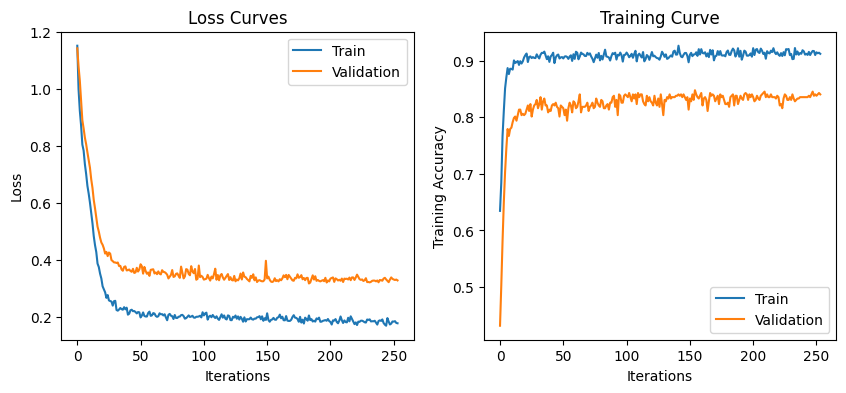

In [568]:
max_len = min(len(iters), len(losses), len(val_losses), len(train_acc), len(val_acc))
print(f"Number of epochs tracked: {max_len}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Loss Curves")
plt.plot(iters[:max_len], losses[:max_len], label="Train")
plt.plot(iters[:max_len], val_losses[:max_len], label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters[:max_len], train_acc[:max_len], label="Train")
plt.plot(iters[:max_len], val_acc[:max_len], label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

# Ladujemy zbior testowy i generujemy predykcje do pliku

In [569]:
with open('zadanie_studenci/test_data.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)

df_t = pd.DataFrame(data[1:], columns=data[0])

missing_values = df_t.isnull().sum()


# do the same data preprocessing as in training dataset

In [570]:
df_t[numerical_columns] = df_t[numerical_columns].apply(pd.to_numeric, errors='coerce')

In [571]:
df_t['TimeToBusStop'] = df_t['TimeToBusStop'].map(bus_stop_mapping_str_to_int)
df_t['TimeToSubway'] = df_t['TimeToSubway'].map(subway_mapping_str_to_int)
df_t['HeatingType'] = df_t['HeatingType'].map(heat_mapping_str_to_int)
df_t['AptManageType'] = df_t['AptManageType'].map(apt_mapping_str_to_int)

df_t['YearBuilt'] = 2015 - df_t['YearBuilt']

df_t = pd.get_dummies(df_t, columns=['HallwayType', 'SubwayStation'])

bool_columns = df_t.select_dtypes(include=['bool']).columns.tolist()
df_t[bool_columns] = df_t[bool_columns].astype(int)

test_data_num = pd.concat([
    df_t[numerical_columns],
    df_t[['TimeToBusStop', 'TimeToSubway', 'HeatingType', 'AptManageType']]
], axis=1)

test_data_scaled = scaler.transform(test_data_num)

df_t[test_data_num.columns] = test_data_scaled

In [572]:
df_t.describe(include='all')

,YearBuilt,Size(sqf),Floor,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,...,HallwayType_mixed,HallwayType_terraced,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
count,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,...,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000
mean,0.325869,0.367995,0.264290,0.935484,0.946802,0.284861,0.428365,0.880306,0.715337,0.407862,...,0.280702,0.610640,0.127334,0.122807,0.016978,0.013016,0.293718,0.250141,0.103565,0.072439
std,0.241096,0.171419,0.177946,0.245740,0.224491,0.316488,0.310161,0.224409,0.314512,0.234918,...,0.449469,0.487743,0.333442,0.328308,0.129225,0.113377,0.455593,0.433217,0.304782,0.259287
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.189189,0.231153,0.119048,1.000000,1.000000,0.015428,0.139288,1.000000,0.500000,0.307692,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.243243,0.351953,0.238095,1.000000,1.000000,0.140252,0.405753,1.000000,0.750000,0.384615,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.594595,0.452316,0.380952,1.000000,1.000000,0.349229,0.604088,1.000000,1.000000,0.538462,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000
max,1.000000,1.000000,0.976190,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [573]:
# Get numerical data
val_data_num = df_t[numerical_columns]

# Add the categorical features that should be treated as numerical
cat_features_to_move = ['TimeToBusStop', 'TimeToSubway', 'HeatingType', 'AptManageType']
val_data_num = pd.concat([val_data_num, df_t[cat_features_to_move]], axis=1)

# Get remaining categorical data (excluding the ones moved to numerical)
val_data_cat = df_t[df_t.columns.difference(numerical_columns)]
val_data_cat = val_data_cat.drop(columns=cat_features_to_move)

# Convert to tensors
val_data_num = torch.tensor(val_data_num.values, dtype=torch.float32)
val_data_cat = torch.tensor(val_data_cat.values, dtype=torch.float32)

test_data = torch.utils.data.TensorDataset(val_data_num, val_data_cat)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

model.eval()
predictions = []
with torch.no_grad():
    for num_data, cat_data in test_loader:
        num_data = num_data.float().to(device)
        cat_data = cat_data.float().to(device)
        outputs = model(num_data, cat_data)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

In [574]:
print(predictions[:10])

[np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]


# save the predictions as a csv file

In [575]:
with open('zadanie_studenci/predictions.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for pred in predictions:
        writer.writerow([pred])

# co jeszcze dodac?
- koniec notebooka lab4 - wagi do przykładów
- inny preprocessing danych jak sie bedzie chciało
- model nie przekopiowany z notebooka z labów
- eksperymentacja z optymizerem
- embedding jak sie bedzie chciało
- walka z przeuczeniem, bachnorm, regularization, weight decay itd.